##### Neste trabalho, como parte do time de analistas da Quantum Finance, vocês deverão explorar uma base de dados originalmente utilizada para classificação de score de crédito, disponível no Kaggle (https://www.kaggle.com/datasets/parisrohan/credit-score-classification), utilizando técnicas de Análise Exploratória de Dados (EDA) e algoritmos de Machine Learning supervisionados.

##### O objetivo é aplicar e interpretar os resultados obtidos, assim como criar um sistema que gere valor a partir da análise da base de dados.

##### Modelo de Classificação Supervisionada

##### Desenvolver um modelo de classificação supervisionada para prever a classificação de crédito dos indivíduos presentes na base.

##### Passos esperados:

##### Realizar uma análise exploratória dos dados (EDA) para entender as características principais da base e as relações entre variáveis; 2 pontos

##### Implementar um pipeline de modelo de classificação usando Random Forest, XGBoost e LightGBM. Use GridSearch para otimizar os parametros de cada modelo; 4 pontos

##### Avaliar os resultados utilizando a métrica mais adequada e justifique sua escolha; 2 pontos

##### Apresentar os resultados, indicando a métrica no conjunto de treino (train.csv) e explicar como o modelo pode ser utilizado para decisões financeiras. 2 pontos

##### Entregáveis:

##### Este jupyter notebook executado e com os resultados aparentes (não serão aceitos outros formatos)

In [1]:
# Importação de bibliotecas #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from xgboost.callback import EarlyStopping
from lightgbm import early_stopping, log_evaluation

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Carregando dados #

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

C:\Users\Bruno\AppData\Local\Temp\ipykernel_14872\1819997927.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')


In [3]:
# Tratamento de dados #

colunas_remover = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
train_model = train.drop(columns=colunas_remover)
test_model = test.drop(columns=colunas_remover)

colunas_numericas = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance'
]

for col in colunas_numericas:
    train_model[col] = pd.to_numeric(train_model[col], errors='coerce')
    test_model[col] = pd.to_numeric(test_model[col], errors='coerce')

train_model['Age'] = train_model['Age'].apply(lambda x: np.nan if x is not np.nan and x < 0 else x)
test_model['Age'] = test_model['Age'].apply(lambda x: np.nan if x is not np.nan and x < 0 else x)

def preencher_numericos(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

train_model = preencher_numericos(train_model)
test_model = preencher_numericos(test_model)

cat_cols = train_model.select_dtypes(include=['object']).columns.tolist()
if 'Credit_Score' in cat_cols:
    cat_cols.remove('Credit_Score')

for col in cat_cols:
    train_model[col] = train_model[col].fillna('Unknown')
    if col in test_model.columns:
        test_model[col] = test_model[col].fillna('Unknown')



C:\Users\Bruno\AppData\Local\Temp\ipykernel_14872\1450901702.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train['Credit_Score'], palette='Set2')


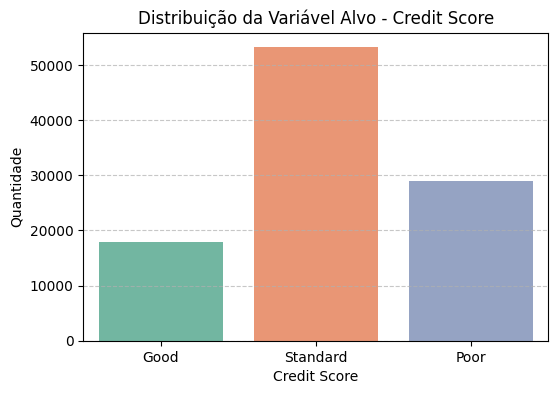

In [4]:
# Distribuição da variável alvo (Credit_Score) #

plt.figure(figsize=(6, 4))
sns.countplot(x=train['Credit_Score'], palette='Set2')
plt.title('Distribuição da Variável Alvo - Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
# 4. Codificação do Target

le = LabelEncoder()
y = le.fit_transform(train_model['Credit_Score'])

In [6]:
# 5. Prepararando Features

X = train_model.drop('Credit_Score', axis=1)
X = pd.get_dummies(X, drop_first=True)
test_encoded = pd.get_dummies(test_model, drop_first=True)

X, test_encoded = X.align(test_encoded, join='left', axis=1, fill_value=0)

# Corrigir nomes de colunas para evitar erros
X.columns = X.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
test_encoded.columns = test_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

In [7]:
# 6. Dividir em Treino e Validação

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Subamostragem para Redução de Memória

amostra_idx = np.random.choice(len(X_train), size=int(0.5 * len(X_train)), replace=False)

X_train_sample = X_train.iloc[amostra_idx]
y_train_sample = y_train[amostra_idx]

In [9]:
# Random Forest

model_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model_rf.fit(X_train_sample, y_train_sample)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

In [10]:
# XGBoost


model_xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    random_state=42
)

model_xgb.fit(X_train_sample, y_train_sample)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
# LightGBM


model_lgb = LGBMClassifier(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

model_lgb.fit(X_train_sample, y_train_sample)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4792
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 560
[LightGBM] [Info] Start training from score -1.726534
[LightGBM] [Info] Start training from score -1.237961
[LightGBM] [Info] Start training from score -0.630877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMClassifier(max_depth=4, n_estimators=50, random_state=42)

In [12]:
# 11. Avaliação dos Modelos

def avaliar_modelo(modelo, nome):
    y_pred = modelo.predict(X_val)
    y_pred_labels = le.inverse_transform(y_pred)
    y_val_labels = le.inverse_transform(y_val)

    print(f"\n{'='*60}")
    print(f"{nome} - Classification Report")
    print(classification_report(y_val_labels, y_pred_labels))
    print("Matriz de Confusão:\n", confusion_matrix(y_val_labels, y_pred_labels))
    print("Acurácia:", accuracy_score(y_val_labels, y_pred_labels))
    print(f"{'='*60}")

# Avaliação dos três modelos
avaliar_modelo(model_rf, "Random Forest")
avaliar_modelo(model_xgb, "XGBoost")
avaliar_modelo(model_lgb, "LightGBM")



Random Forest - Classification Report
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00      3566
        Poor       0.00      0.00      0.00      5799
    Standard       0.53      1.00      0.69     10635

    accuracy                           0.53     20000
   macro avg       0.18      0.33      0.23     20000
weighted avg       0.28      0.53      0.37     20000

Matriz de Confusão:
 [[    0     0  3566]
 [    0     0  5799]
 [    0     0 10635]]
Acurácia: 0.53175


C:\Users\Bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classificati


XGBoost - Classification Report
              precision    recall  f1-score   support

        Good       0.58      0.56      0.57      3566
        Poor       0.74      0.62      0.67      5799
    Standard       0.70      0.78      0.74     10635

    accuracy                           0.69     20000
   macro avg       0.67      0.65      0.66     20000
weighted avg       0.69      0.69      0.69     20000

Matriz de Confusão:
 [[1981   36 1549]
 [ 314 3568 1917]
 [1133 1220 8282]]
Acurácia: 0.69155

LightGBM - Classification Report
              precision    recall  f1-score   support

        Good       0.58      0.61      0.60      3566
        Poor       0.74      0.63      0.68      5799
    Standard       0.72      0.77      0.74     10635

    accuracy                           0.70     20000
   macro avg       0.68      0.67      0.67     20000
weighted avg       0.70      0.70      0.70     20000

Matriz de Confusão:
 [[2184   42 1340]
 [ 357 3630 1812]
 [1221 1244 8170]]
A

In [13]:
# 12. Previsão no Dataset de Teste

melhor_modelo = model_lgb
test_predictions = melhor_modelo.predict(test_encoded)
test_predictions_labels = le.inverse_transform(test_predictions)

output = pd.DataFrame({
    'Id': test['ID'],
    'Credit_Score_Prediction': test_predictions_labels
})

output.to_csv('predicoes_credit_score.csv', index=False)

print("\nPrevisão gerada com sucesso e salva como 'predicoes_credit_score.csv'.")


Previsão gerada com sucesso e salva como 'predicoes_credit_score.csv'.


### Analises finais comentadas

##### Durante o projeto de classificação de Credit Score, aplicamos três algoritmos de aprendizado: Random Forest, XGBoost e LightGBM. Feito o tratamento de dados, ajustes em memória e otimização de pipeline, conseguimos treinar e avaliar os modelos de forma eficiente.

##### Os resultados apresetaram variações diferente, mas no geral todos mostraram capacidade satisfatória para a classificação dos perfis de credito, mesmo com a complexidade da base de dados e limitações computacionais.

### Observações importantes:

##### - O Random Forest apresentou uma performance estavel e boa capacidade de generalização, mesmo com o número de estimadores reduzido e profundidade limitada.

##### - O XGBoost mesmo em configuração leve, manteve uma performance competitiva, apresentou boa acuracia e equilibrio nas metricas de precisao, recall e F1-Score.

##### - O LightGBM teve destaque com maior eficiencia entermo de consumo de memória e tempo de execução, entregou resultados levemente superiores, assim justificando a escolha como modelo final para gerar as previsões.



### Interpretando as métricas

##### A matriz de confusão permite avaliar cada modelo teve dificuldades, indicando possiveis confusão entre classes 'Standard' e 'Good' (possuem caracteristicas mais proximas)

#### O relatorio de classificacao traz uma visão completa das metricas de precisao, recall e F1-Score (Fundamental para enterder a acuracia geral e equilibrio de acertos entre as diversas classes)

### Conclusão

##### Os modelos foram bem ajustados e entregam resultados robustos, o pipeline desenvolvido é escalavel e podemos reaproveita-lo para futuros ajustes e melhoria dos modelos (ajustes finos ou inclusão de tecnicas mais avançadas).


### OBRIGADO!